# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): AC209

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

import seaborn as sns
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

In [2]:
df = pd.read_csv('hw6_dataset.csv')

In [3]:
df.head()

,-1.439999999999999891e-01,-1.429999999999999882e-01,-1.160000000000000059e-01,-1.029999999999999943e-01,2.260000000000000064e-01,2.099999999999999922e-01,-9.799999999999999822e-01,-7.800000000000000266e-01,-4.739999999999999769e-01,-4.470000000000000084e-01,...,9.250000000000000444e-01,5.160000000000000142e-01,3.439999999999999725e-01,9.060000000000000275e-01,-1.129999999999999893e+00,-5.520000000000000462e-01,5.530000000000000471e-01,-4.169999999999999818e-01,2.560000000000000053e-01,0.000000000000000000e+00
0,-0.01100,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
1,0.21200,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0.0
2,0.21500,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0.0
3,0.27900,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0
4,0.00922,-0.138,0.1690,0.1540,-0.391,-0.397,-1.6900,-1.450,-0.546,-0.527,...,-0.277,0.699,0.37100,0.481,-1.0600,-0.526,0.550,-0.284,0.1550,0.0


## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [4]:
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

In [5]:
data_train.head()

,-1.439999999999999891e-01,-1.429999999999999882e-01,-1.160000000000000059e-01,-1.029999999999999943e-01,2.260000000000000064e-01,2.099999999999999922e-01,-9.799999999999999822e-01,-7.800000000000000266e-01,-4.739999999999999769e-01,-4.470000000000000084e-01,...,9.250000000000000444e-01,5.160000000000000142e-01,3.439999999999999725e-01,9.060000000000000275e-01,-1.129999999999999893e+00,-5.520000000000000462e-01,5.530000000000000471e-01,-4.169999999999999818e-01,2.560000000000000053e-01,0.000000000000000000e+00
0,-0.0110,0.138,-0.223,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.4520,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
3,0.2790,-0.197,0.127,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.4850,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0
5,0.0569,0.192,0.302,0.2720,-0.484,-0.473,0.3480,0.256,-0.607,-0.355,...,0.206,-0.0599,-1.07000,-0.536,0.8640,0.527,0.282,0.817,-0.2830,0.0
6,0.0184,0.101,-0.681,-0.5900,1.530,1.500,-0.5560,-0.428,-0.583,-0.772,...,0.124,0.3070,0.35700,-0.380,0.1580,0.846,0.704,0.760,-0.1250,0.0
9,-0.0748,-0.432,0.923,0.7930,-1.040,-1.010,-1.9500,-1.560,-0.590,-0.575,...,-1.270,1.3600,0.38700,1.290,-1.2100,-2.050,-0.357,-2.540,0.7670,0.0


#### Part 2 ####

In [6]:
Y_train = data_train.iloc[:, -1].reset_index(drop=True)
X_train = data_train.iloc[:, 0:-2].reset_index(drop=True)

Y_test = data_test.iloc[:, -1].reset_index(drop=True)
X_test = data_test.iloc[:, 0:-2].reset_index(drop=True)

X_train.head()

,-1.439999999999999891e-01,-1.429999999999999882e-01,-1.160000000000000059e-01,-1.029999999999999943e-01,2.260000000000000064e-01,2.099999999999999922e-01,-9.799999999999999822e-01,-7.800000000000000266e-01,-4.739999999999999769e-01,-4.470000000000000084e-01,...,4.259999999999999898e-01,-7.379999999999999893e-01,9.250000000000000444e-01,5.160000000000000142e-01,3.439999999999999725e-01,9.060000000000000275e-01,-1.129999999999999893e+00,-5.520000000000000462e-01,5.530000000000000471e-01,-4.169999999999999818e-01
0,-0.0110,0.138,-0.223,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.558000,0.420,-0.593,0.4520,0.00785,-0.533,-0.0789,0.705,0.906,0.216
1,0.2790,-0.197,0.127,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,1.040000,-0.688,-0.640,0.4850,0.29500,0.403,-1.1200,-0.343,0.468,-0.820
2,0.0569,0.192,0.302,0.2720,-0.484,-0.473,0.3480,0.256,-0.607,-0.355,...,-0.000909,0.277,0.206,-0.0599,-1.07000,-0.536,0.8640,0.527,0.282,0.817
3,0.0184,0.101,-0.681,-0.5900,1.530,1.500,-0.5560,-0.428,-0.583,-0.772,...,0.313000,-0.338,0.124,0.3070,0.35700,-0.380,0.1580,0.846,0.704,0.760
4,-0.0748,-0.432,0.923,0.7930,-1.040,-1.010,-1.9500,-1.560,-0.590,-0.575,...,0.156000,-1.480,-1.270,1.3600,0.38700,1.290,-1.2100,-2.050,-0.357,-2.540


In [7]:
log_model_cv = LogisticRegressionCV(Cs=9, cv=5, penalty='l2')
log_model_cv.fit(X_train, Y_train)

LogisticRegressionCV(Cs=9, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [8]:
log_model_accuracy = log_model_cv.score(X_test, Y_test)
all_0_model_accuracy = (Y_test==0).mean()
print('Logistic Model Accuracy: %.3f%%' % (log_model_accuracy*100))
print('All 0 Model Accuracy: %.3f%%' % (all_0_model_accuracy*100))

Logistic Model Accuracy: 99.532%
All 0 Model Accuracy: 99.391%


Based on the accuracies only, the logistic model does not have an advantage compare to the all 0 model, as the number of label 1 is too small compared to the total number of patients.

#### Part 3 and 4 ####

In [9]:
from sklearn.metrics import confusion_matrix
Y_test_pred = log_model_cv.predict(X_test)
cm_log = confusion_matrix(Y_test, Y_test_pred)
cm_log

array([[16976,     8],
       [   72,    32]])

In [10]:
cm_all_0 = confusion_matrix(Y_test, np.zeros(len(Y_test)))
cm_all_0

array([[16984,     0],
       [  104,     0]])

In [11]:
TN_logistic = cm_log[0][0]/((Y_test==0).sum()) * 100
TP_logistic = cm_log[1][1]/((Y_test==1).sum()) * 100
TN_all_0 = cm_all_0[0][0]/((Y_test==0).sum()) * 100
TP_all_0 = cm_all_0[1][1]/((Y_test==1).sum()) * 100

print('Logistic Model True Negative Rate: %.3f%%' % TN_logistic)
print('Logistic Model True Positive Rate: %.3f%%' % TP_logistic)
print('All 0 Model True Negative Rate: %.3f%%' % TN_all_0)
print('All 0 Model True Positive Rate: %.3f%%' % TP_all_0)

Logistic Model True Negative Rate: 99.953%
Logistic Model True Positive Rate: 30.769%
All 0 Model True Negative Rate: 100.000%
All 0 Model True Positive Rate: 0.000%


True positive and true negative stand for the correct prediction of positive and negative respectively.
The true negative metrics play a minimal role here as the total number of negative is too large.
However, from the true positive metrics we can see that the logistic model has 30% accuracy. Comparing to the 0% (of course) accuracy of the all 0 model, we can safely say that the logitic model is a better model.

#### Part 5 ####

In [12]:
FP_logistic = cm_log[0][1]/((Y_test==0).sum()) * 100
print('Logistic Model False Positive Rate: %.3f%%' % FP_logistic)

Logistic Model False Positive Rate: 0.047%


False Positive rate + True negative rate = 1

In cancer detection task, higher false positive rate will cause larger number of normal patients to be diagnosed as cancer patients, which will cause unnecessary costly treament and mental burden.

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

#### Part 1 ####

In [13]:
log_fpr, log_tpr, log_th = metrics.roc_curve(Y_test, log_model_cv.predict_proba(X_test)[:, 1])
all_0_fpr, all_0_tpr, all_0_th = metrics.roc_curve(Y_test, np.zeros(len(Y_test)))

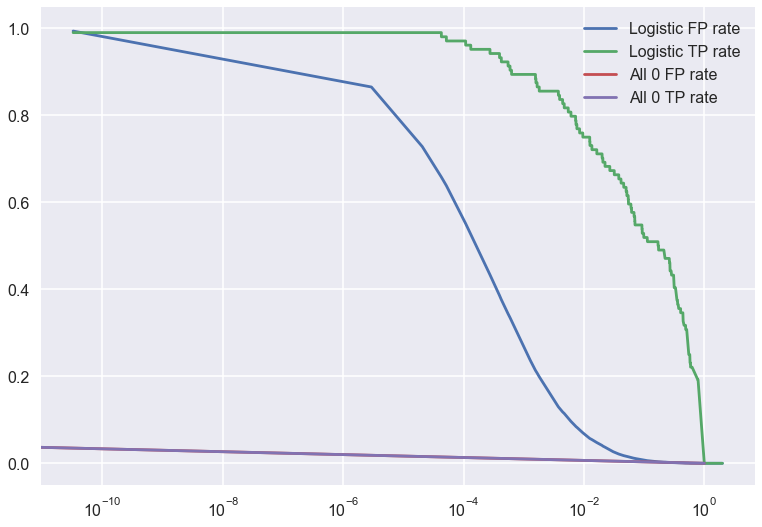

In [14]:
sns.set_context('poster')
plt.plot(log_th[:-2], log_fpr[:-2], label='Logistic FP rate')
plt.plot(log_th[:-2], log_tpr[:-2], label='Logistic TP rate')
plt.plot(all_0_th, all_0_fpr, label='All 0 FP rate')
plt.plot(all_0_th, all_0_tpr, label='All 0 TP rate')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

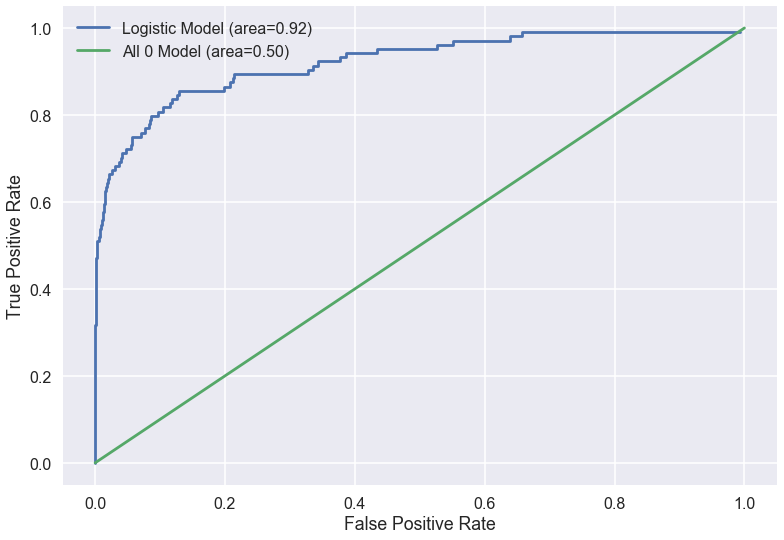

In [15]:
sns.set_context('poster')
plt.plot(log_fpr[:-2], log_tpr[:-2], label='Logistic Model (area=%.2f)' % metrics.auc(log_fpr, log_tpr))
plt.plot(all_0_fpr, all_0_tpr, label='All 0 Model (area=%.2f)' % metrics.auc(all_0_fpr, all_0_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

The all 0 model has FP and TP rate curve to be 0 regardless of the threshold setting.
The false positive rate decreases from 1 to 0 faster than the true positive rate as the threshold increases

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [16]:
df_miss = pd.read_csv('HW6_dataset_missing.csv', index_col=0)
df_miss.shape

(24999, 118)

#### Part 1 ####

In [17]:
df_miss_drop = df_miss.dropna()

In [18]:
df_miss_drop.shape

(1436, 118)

In [19]:
np.random.seed(9001)
msk = np.random.rand(len(df_miss_drop)) < 0.75
data_train_drop = df_miss_drop[msk]
data_test_drop = df_miss_drop[~msk]

In [20]:
Y_train_drop = data_train_drop.iloc[:, -1].reset_index(drop=True)
X_train_drop = data_train_drop.iloc[:, :-1].reset_index(drop=True)

Y_test_drop = data_test_drop.iloc[:, -1].reset_index(drop=True)
X_test_drop = data_test_drop.iloc[:, :-1].reset_index(drop=True)

X_train_drop.shape

(1080, 117)

In [21]:
log_model_cv_drop = LogisticRegressionCV(Cs=9, cv=5, penalty='l2')
log_model_cv_drop.fit(X_train_drop, Y_train_drop)

D:\ProgramData\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=9, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [22]:
log_model_drop_accuracy = log_model_cv_drop.score(X_test_drop, Y_test_drop)
print('Logistic Model Accuracy: %.3f%%' % (log_model_drop_accuracy*100))

Logistic Model Accuracy: 99.438%


In [23]:
cm_log_drop = confusion_matrix(Y_test_drop, log_model_cv_drop.predict(X_test_drop))
TP_logistic = cm_log_drop[1][1]/(cm_log_drop[1].sum()) * 100
print('Logistic Model True Positive Rate: %.3f%%' % TP_logistic)

Logistic Model True Positive Rate: 0.000%


In [24]:
confusion_matrix(Y_test_drop, log_model_cv_drop.predict(X_test_drop))

array([[354,   0],
       [  2,   0]])

#### Part 2 ####

In [25]:
df_miss_mean = df_miss.copy()

In [26]:
for c in df_miss_mean.columns:
    df_miss_mean[c] = df_miss[c].fillna(df_miss[c].dropna().mean())

In [27]:
df_miss_mean.notnull().all().all()

True

In [28]:
np.random.seed(9001)
msk = np.random.rand(len(df_miss_mean)) < 0.75
data_train_mean = df_miss_mean[msk]
data_test_mean = df_miss_mean[~msk]

In [29]:
Y_train_mean = data_train_mean.iloc[:, -1].reset_index(drop=True)
X_train_mean = data_train_mean.iloc[:, :-1].reset_index(drop=True)

Y_test_mean = data_test_mean.iloc[:, -1].reset_index(drop=True)
X_test_mean = data_test_mean.iloc[:, :-1].reset_index(drop=True)

X_train_mean.shape

(18874, 117)

In [30]:
log_model_cv_mean = LogisticRegressionCV(Cs=9, cv=5, penalty='l2')
log_model_cv_mean.fit(X_train_mean, Y_train_mean)

LogisticRegressionCV(Cs=9, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [31]:
log_model_mean_accuracy = log_model_cv_mean.score(X_test_mean, Y_test_mean)
print('Logistic Model Accuracy: %.3f%%' % (log_model_mean_accuracy*100))

Logistic Model Accuracy: 99.265%


In [32]:
cm_log_mean = confusion_matrix(Y_test_mean, log_model_cv_mean.predict(X_test_mean))
TP_logistic = cm_log_mean[1][1]/(cm_log_mean[1].sum()) * 100
print('Logistic Model True Positive Rate: %.3f%%' % TP_logistic)

Logistic Model True Positive Rate: 11.765%


In [33]:
cm_log_mean

array([[6074,    0],
       [  45,    6]])

#### Part 3 ####

In [34]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
df_miss_model = df_miss.copy()
df_cols = df_miss_model.columns
Y_miss_model = df_miss_model.copy().iloc[:, -1]
X_miss_model = df_miss_model.copy().iloc[:, :-1]

In [47]:
X_miss_model.dropna().shape

(1436, 117)

In [48]:
miss_cols = np.where(X_miss_model.isnull().sum(axis=0) != 0)[0]
miss_cols

array([ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108], dtype=int64)

In [49]:
# Since there are only 17 columns that have missing data
# we can build models based on the rest 100 columns and impute the missing data

for c in miss_cols:
    print('Processing Column: %d' % c)
    ind_valid = np.where(X_miss_model.iloc[:, c].notnull())[0]
    ind_miss = np.where(X_miss_model.iloc[:, c].isnull())[0]
    
    X_valid_response = X_miss_model.iloc[ind_valid, c]
    X_valid_predictor = X_miss_model.drop(df_cols[miss_cols], axis=1).iloc[ind_valid, :]
    X_miss_predictor = X_miss_model.drop(df_cols[miss_cols], axis=1).iloc[ind_miss, :]
    
    knn_model = KNeighborsRegressor(n_neighbors = 3)
    knn_model.fit(X_valid_predictor, X_valid_response)
    
    X_miss_model.iloc[ind_miss, c] = knn_model.predict(X_miss_predictor)

Processing Column: 92
Processing Column: 93
Processing Column: 94
Processing Column: 95
Processing Column: 96
Processing Column: 97
Processing Column: 98
Processing Column: 99
Processing Column: 100
Processing Column: 101
Processing Column: 102
Processing Column: 103
Processing Column: 104
Processing Column: 105
Processing Column: 106
Processing Column: 107
Processing Column: 108


In [50]:
X_miss_model.dropna().shape

(24999, 117)

In [51]:
np.random.seed(9001)
msk = np.random.rand(len(X_miss_model)) < 0.75
X_miss_train = X_miss_model[msk]
Y_miss_train = Y_miss_model[msk]
X_miss_test = X_miss_model[~msk]
Y_miss_test = Y_miss_model[~msk]

In [52]:
log_model_impute = LogisticRegressionCV(Cs=9, cv=5, penalty='l2')
log_model_impute.fit(X_miss_train, Y_miss_train)

LogisticRegressionCV(Cs=9, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [53]:
log_model_impute_accuracy = log_model_impute.score(X_miss_test, Y_miss_test)
print('Logistic Model Accuracy: %.3f%%' % (log_model_impute_accuracy*100))

Logistic Model Accuracy: 99.233%


In [54]:
cm_log_impute = confusion_matrix(Y_miss_test, log_model_impute.predict(X_miss_test))
TP_logistic = cm_log_impute[1][1]/(cm_log_impute[1].sum()) * 100
print('Logistic Model True Positive Rate: %.3f%%' % TP_logistic)

Logistic Model True Positive Rate: 19.608%


In [55]:
cm_log_impute

array([[6068,    6],
       [  41,   10]])

#### Part 4 ####

All three methods have similar accuracy > 99%, which is expected as most of the classes are 0.
However, we can clearly see improvement on the true positive rate as the imputation complexity increases.
Dropping all missing data is a method with minimal compuation complexity, but it is not a appropriate model here as most of the observations have at least one missing data.
Imputation with mean improves the true positive rate a little bit without too much computation.
Imputation with modeling (kNN is used here) requires the higher computational complexity among these three methods. However, it provide the best true positive prediction (though come with with some false positives). This makes sense as the missing data are predicted by building models on all valid data (majority). If the predictors' correlation is high then imputation by model will give a great performance boost on the true positive rate, as shown in part 3

## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.


#### Part 1 ####

\begin{align}
l_i(\theta_i) &= \log f(y_i|\theta_i) \\
&= \log (h(y_i) e^{y_i\theta_i - b(\theta_i)})\\
&= y_i\theta_i - b(\theta_i) + \log (h(y_i))
\end{align}

#### Part 2 ####

\begin{align}
\frac{\partial l_i}{\partial \beta_j} &= \frac{\partial l_i}{\partial \theta_i} \frac{\partial \theta_i}{\partial \beta_j} \\
\end{align}

#### Part 3 ####

\begin{align}
\frac{\partial l_i}{\partial \theta_i} &= y_i - b'(\theta_i)
\end{align}

#### Part 4 ####

From part 3 we know $$\mu_i = b'(\theta_i)$$
then
\begin{align}
\frac{\partial \theta_i}{\partial \mu_i} &= (\frac{\partial \mu_i}{\partial \theta_i})^{-1}\\
&= \frac {1}{b''(\theta_i)}
\end{align}

#### Part 5 ####

#### Part 6 ####

#### Part 7 ####

#### Part 8 ####